# Προεπεξεργασία δεδομένων κατανάλωσης ενέργειας

Σε αυτό το notebook καθαρίζουμε τα αρχικά δεδομένα κατανάλωσης ενέργειας του νοικοκυριού, χειριζόμαστε ελλιπείς ή μη έγκυρες τιμές, οργανώνουμε σωστά τον χρόνο (datetime) και επαναδειγματοληπτούμε σε ημερήσιο επίπεδο. Στο τέλος δημιουργούμε τα βασικά χαρακτηριστικά (features) που θα χρησιμοποιηθούν αργότερα για ταξινόμηση, παλινδρόμηση, ομαδοποίηση, κανόνες συσχέτισης και πρόβλεψη χρονοσειρών, σύμφωνα με την εκφώνηση της εργασίας.

In [1]:
# Βασικές βιβλιοθήκες για φόρτωμα, ανάλυση και οπτικοποίηση δεδομένων
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Ρυθμίσεις εμφάνισης για πιο ευανάγνωστα outputs
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

sns.set(style="whitegrid")

In [2]:
# Φόρτωμα των αρχικών δεδομένων κατανάλωσης από το αρχείο κειμένου
raw_data_path = "../data/household_power_consumption.txt"

# Το αρχείο είναι ημι-αποδιαμορφωμένο: διαχωριστής ';', ελλιπείς τιμές με '?'
df_raw = pd.read_csv(
    raw_data_path,
    sep=";",
    na_values=["?"],
    low_memory=False
)

print("Σχήμα αρχικού πίνακα:", df_raw.shape)
print("\nΤύποι στηλών:")
print(df_raw.dtypes)

print("\nΠρώτες γραμμές των δεδομένων:")
df_raw.head()

Σχήμα αρχικού πίνακα: (2075259, 9)

Τύποι στηλών:
Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

Πρώτες γραμμές των δεδομένων:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
# Γρήγορη πρώτη εξερεύνηση: ελλιπείς τιμές και βασικά στατιστικά
print("Σύνολο ελλιπών τιμών ανά στήλη:")
missing_counts = df_raw.isna().sum()
print(missing_counts)

print("\nΠοσοστό ελλιπών τιμών ανά στήλη (%):")
missing_percent = (missing_counts / len(df_raw)) * 100
print(missing_percent.round(3))

print("\nΒασικά στατιστικά για τις αριθμητικές στήλες:")
display(df_raw.describe().T)

Σύνολο ελλιπών τιμών ανά στήλη:
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Ποσοστό ελλιπών τιμών ανά στήλη (%):
Date                     0.000
Time                     0.000
Global_active_power      1.252
Global_reactive_power    1.252
Voltage                  1.252
Global_intensity         1.252
Sub_metering_1           1.252
Sub_metering_2           1.252
Sub_metering_3           1.252
dtype: float64

Βασικά στατιστικά για τις αριθμητικές στήλες:


,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122
Global_reactive_power,2049280.0,0.123714,0.112722,0.000,0.048,0.100,0.194,1.390
Voltage,2049280.0,240.839858,3.239987,223.200,238.990,241.010,242.890,254.150
Global_intensity,2049280.0,4.627759,4.444396,0.200,1.400,2.600,6.400,48.400
Sub_metering_1,2049280.0,1.121923,6.153031,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2049280.0,1.298520,5.822026,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2049280.0,6.458447,8.437154,0.000,0.000,1.000,17.000,31.000


## Πρώτα διαγράμματα κατανομής

Σε αυτό το σημείο εξετάζουμε οπτικά την κατανομή βασικών μεγεθών κατανάλωσης (global ενεργή ισχύς, τάση, ένταση και υπομετρητές), ώστε να επιβεβαιώσουμε ότι τα δεδομένα είναι ρεαλιστικά και συμβατά με τα στατιστικά που είδαμε παραπάνω.

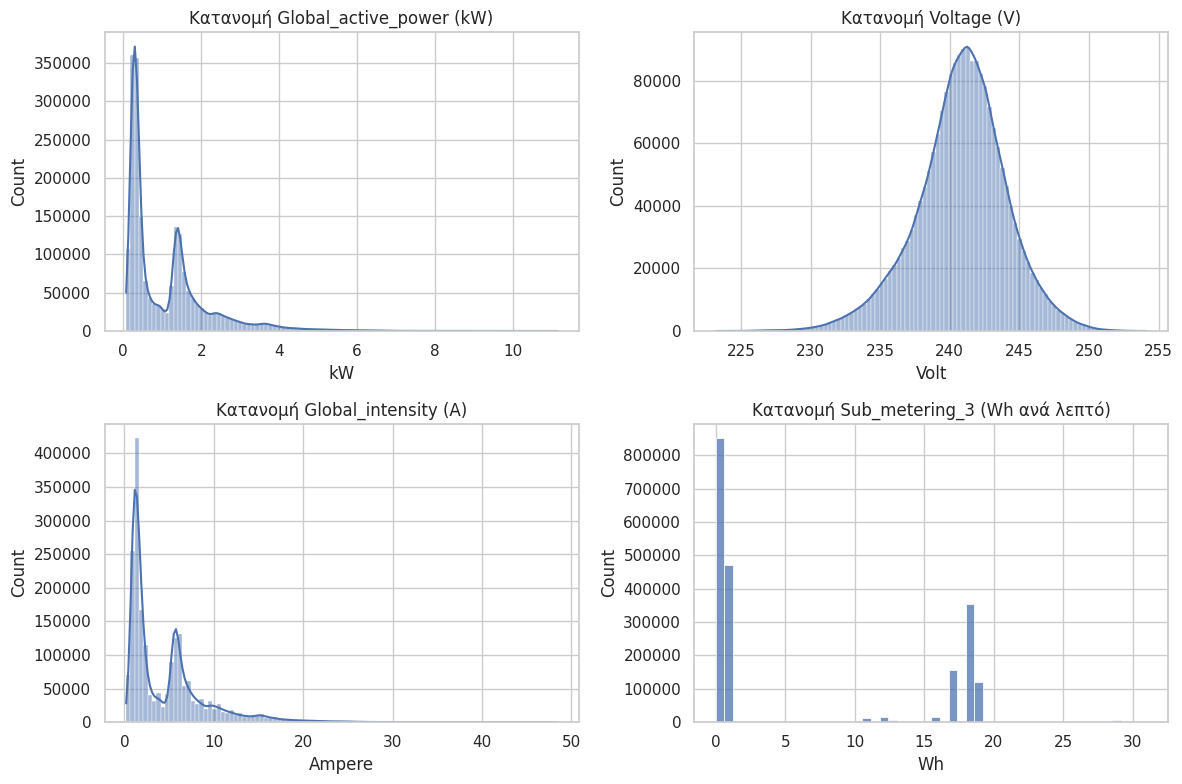

In [4]:
# Διαγράμματα κατανομής για βασικά μεγέθη κατανάλωσης
from pathlib import Path

results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Κατανομή Global_active_power
sns.histplot(df_raw["Global_active_power"].dropna(), bins=100, ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Κατανομή Global_active_power (kW)")
axes[0, 0].set_xlabel("kW")

# Κατανομή Voltage
sns.histplot(df_raw["Voltage"].dropna(), bins=100, ax=axes[0, 1], kde=True)
axes[0, 1].set_title("Κατανομή Voltage (V)")
axes[0, 1].set_xlabel("Volt")

# Κατανομή Global_intensity
sns.histplot(df_raw["Global_intensity"].dropna(), bins=100, ax=axes[1, 0], kde=True)
axes[1, 0].set_title("Κατανομή Global_intensity (A)")
axes[1, 0].set_xlabel("Ampere")

# Κατανομή Sub_metering_3 (πιο ενεργός υπομετρητής)
sns.histplot(df_raw["Sub_metering_3"].dropna(), bins=50, ax=axes[1, 1])
axes[1, 1].set_title("Κατανομή Sub_metering_3 (Wh ανά λεπτό)")
axes[1, 1].set_xlabel("Wh")

plt.tight_layout()

# Αποθήκευση του σχήματος στον φάκελο results
raw_dist_path = results_dir / "raw_distributions.png"
fig.savefig(raw_dist_path, bbox_inches="tight")

plt.show()

### Σύντομος σχολιασμός των διαγραμμάτων

Από τα ιστογράμματα της `Global_active_power` και της `Global_intensity` φαίνεται ότι οι περισσότερες μετρήσεις αντιστοιχούν σε χαμηλή–μεσαία κατανάλωση, με σχετικά λίγες αλλά σαφείς κορυφές υψηλής κατανάλωσης. Η τάση (`Voltage`) συγκεντρώνεται γύρω από τα ~241V με μικρές διακυμάνσεις, όπως θα περιμέναμε σε οικιακό δίκτυο. Ο υπομετρητής 3 (`Sub_metering_3`) είναι μηδενικός στο μεγαλύτερο μέρος του χρόνου και ενεργοποιείται έντονα μόνο σε ορισμένα διαστήματα, κάτι που ταιριάζει με τη χρήση θερμοσίφωνα/κλιματισμού. Αυτή η εικόνα μας βοηθά να καταλάβουμε καλύτερα τη συμπεριφορά του νοικοκυριού πριν περάσουμε σε ημερήσια αθροίσματα και δημιουργία χαρακτηριστικών.

## Μετατροπή Date + Time σε datetime

Στη συνέχεια δημιουργούμε μία ενιαία στήλη χρονικής σήμανσης από τις στήλες `Date` και `Time`, τη μετατρέπουμε σε τύπο datetime και ταξινομούμε χρονικά τα δεδομένα, ώστε να είναι έτοιμα για ημερήσιο resampling και υπολογισμό χαρακτηριστικών.

In [5]:
# Δημιουργία ενιαίας στήλης datetime και ταξινόμηση
# Προσοχή: το format στο αρχείο είναι ΗΗ/ΜΜ/ΕΕΕΕ και ώρα HH:MM:SS

df_raw["Datetime"] = pd.to_datetime(
    df_raw["Date"] + " " + df_raw["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)

# Έλεγχος για τυχόν αποτυχημένες μετατροπές
invalid_datetimes = df_raw["Datetime"].isna().sum()
print("Αριθμός μη έγκυρων datetime μετά τη μετατροπή:", invalid_datetimes)

# Ταξινόμηση βάσει Datetime και επαναφορά ευρετηρίου
df_raw = df_raw.sort_values("Datetime").reset_index(drop=True)

print("\nΕύρος ημερομηνιών μετά την ταξινόμηση:")
print("Από:", df_raw["Datetime"].min())
print("Έως:", df_raw["Datetime"].max())

# Έλεγχος για διπλές χρονικές σφραγίδες
duplicate_timestamps = df_raw["Datetime"].duplicated().sum()
print("\nΠλήθος διπλών χρονικών στιγμών:", duplicate_timestamps)

# Μικρή προεπισκόπηση της νέας στήλης
print("\nΠρώτες γραμμές με τη στήλη Datetime:")
display(df_raw[["Date", "Time", "Datetime"]].head())

Αριθμός μη έγκυρων datetime μετά τη μετατροπή: 0

Εύρος ημερομηνιών μετά την ταξινόμηση:
Από: 2006-12-16 17:24:00
Έως: 2010-11-26 21:02:00

Πλήθος διπλών χρονικών στιγμών: 0

Πρώτες γραμμές με τη στήλη Datetime:


,Date,Time,Datetime
0,16/12/2006,17:24:00,2006-12-16 17:24:00
1,16/12/2006,17:25:00,2006-12-16 17:25:00
2,16/12/2006,17:26:00,2006-12-16 17:26:00
3,16/12/2006,17:27:00,2006-12-16 17:27:00
4,16/12/2006,17:28:00,2006-12-16 17:28:00


## Δημιουργία ημερήσιου πίνακα κατανάλωσης

Σε αυτό το βήμα χρησιμοποιούμε τη στήλη `Datetime` ως χρονικό ευρετήριο, επαναδειγματοληπτούμε τα δεδομένα σε ημερήσιο επίπεδο και δημιουργούμε έναν πρώτο ημερήσιο πίνακα (`df_daily`) με βασικά αθροίσματα και μέσους όρους. Παράλληλα μετράμε πόσα λεπτά μετρήσεων λείπουν ανά ημέρα, ώστε αργότερα να μπορούμε να φιλτράρουμε ημέρες κακής ποιότητας πριν εκπαιδεύσουμε μοντέλα ταξινόμησης, παλινδρόμησης και clustering.

In [6]:
# Επαναδειγματοληψία σε ημερήσιο επίπεδο και βασικά aggregates

# Ορίζουμε τη Datetime ως ευρετήριο για χρονοσειρές
if df_raw.index.name != "Datetime":
    df_raw = df_raw.set_index("Datetime")

# Αναμενόμενος αριθμός μετρήσεων ανά ημέρα (1 μέτρηση ανά λεπτό)
EXPECTED_PER_DAY = 24 * 60

# Πόσες μετρήσεις έχουμε ανά ημέρα για την Global_active_power
daily_counts = df_raw["Global_active_power"].resample("D").count()

# Βασικός ημερήσιος πίνακας
df_daily = pd.DataFrame(index=daily_counts.index)
df_daily["n_measurements"] = daily_counts

df_daily["missing_minutes"] = EXPECTED_PER_DAY - df_daily["n_measurements"]
df_daily["missing_ratio"] = df_daily["missing_minutes"] / EXPECTED_PER_DAY

# Ημερήσια συνολική ενεργός ενέργεια σε kWh
# Η Global_active_power είναι σε kW ανά λεπτό, οπότε ενέργεια ανά μέρα = sum(power) * (1/60)
df_daily["daily_total_active_energy_kwh"] = (
    df_raw["Global_active_power"].resample("D").sum() / 60.0
)

# Ημερήσιοι μέσοι όροι τάσης και έντασης
df_daily["daily_mean_voltage"] = df_raw["Voltage"].resample("D").mean()
df_daily["daily_mean_intensity"] = df_raw["Global_intensity"].resample("D").mean()

# Ημερήσια αθροίσματα υπομετρητών (Wh ανά λεπτό -> Wh ανά ημέρα)
df_daily["daily_sub1_wh"] = df_raw["Sub_metering_1"].resample("D").sum()
df_daily["daily_sub2_wh"] = df_raw["Sub_metering_2"].resample("D").sum()
df_daily["daily_sub3_wh"] = df_raw["Sub_metering_3"].resample("D").sum()

print("Σχήμα ημερήσιου πίνακα:", df_daily.shape)
print("\nΠερίληψη missing_ratio ανά ημέρα:")
print(df_daily["missing_ratio"].describe())

print("\nΠρώτες γραμμές του df_daily:")
display(df_daily.head())

Σχήμα ημερήσιου πίνακα: (1442, 9)

Περίληψη missing_ratio ανά ημέρα:
count    1442.000000
mean        0.013099
std         0.105488
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: missing_ratio, dtype: float64

Πρώτες γραμμές του df_daily:


,n_measurements,missing_minutes,missing_ratio,daily_total_active_energy_kwh,daily_mean_voltage,daily_mean_intensity,daily_sub1_wh,daily_sub2_wh,daily_sub3_wh
Datetime,,,,,,,,,
2006-12-16,396,1044,0.725,20.152933,236.243763,13.082828,0.0,546.0,4926.0
2006-12-17,1440,0,0.000,56.507667,240.087028,9.999028,2033.0,4187.0,13341.0
2006-12-18,1440,0,0.000,36.730433,241.231694,6.421667,1063.0,2621.0,14018.0
2006-12-19,1440,0,0.000,27.769900,241.999313,4.926389,839.0,7602.0,6197.0
2006-12-20,1440,0,0.000,37.095800,242.308062,6.467361,0.0,2648.0,14063.0


## Έλεγχος ποιότητας ημερών και κατανομή ημερήσιας ενέργειας

Εξετάζουμε την κατανομή της ημερήσιας συνολικής ενέργειας και του λόγου ελλιπών μετρήσεων (`missing_ratio`) ανά ημέρα. Στόχος είναι να εντοπίσουμε μέρες με πολλά κενά δεδομένων και να καταλάβουμε σε ποιο εύρος κινούνται οι «φυσιολογικές» τιμές κατανάλωσης, πριν αποφασίσουμε κανόνες φιλτραρίσματος για τα supervised μοντέλα.

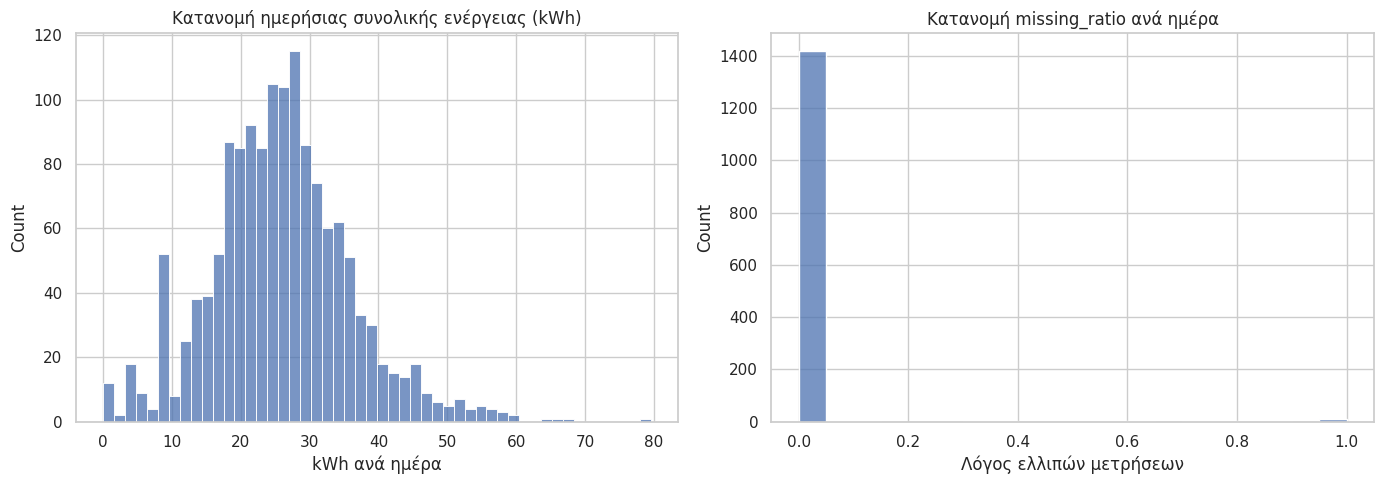

Ημέρες με missing_ratio > 0.1: 24 από 1442


In [7]:
# Κατανομή ημερήσιας ενέργειας και missing_ratio
from pathlib import Path

results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ιστόγραμμα ημερήσιας συνολικής ενεργού ενέργειας (kWh)
sns.histplot(df_daily["daily_total_active_energy_kwh"].dropna(), bins=50, ax=axes[0])
axes[0].set_title("Κατανομή ημερήσιας συνολικής ενέργειας (kWh)")
axes[0].set_xlabel("kWh ανά ημέρα")

# Ιστόγραμμα missing_ratio
sns.histplot(df_daily["missing_ratio"], bins=20, ax=axes[1])
axes[1].set_title("Κατανομή missing_ratio ανά ημέρα")
axes[1].set_xlabel("Λόγος ελλιπών μετρήσεων")

plt.tight_layout()

# Αποθήκευση του σχήματος στον φάκελο results
daily_dist_path = results_dir / "daily_energy_missing_ratio.png"
fig.savefig(daily_dist_path, bbox_inches="tight")

plt.show()

# Ενδεικτικός έλεγχος για μέρες με πολλά κενά
threshold_missing = 0.1
n_bad_days = (df_daily["missing_ratio"] > threshold_missing).sum()
print(f"Ημέρες με missing_ratio > {threshold_missing}: {n_bad_days} από {len(df_daily)}")

## Κανόνας ποιότητας ημερών με βάση το missing_ratio

Μετά την πρώτη διερεύνηση της ημερήσιας συνολικής ενέργειας και του `missing_ratio` είδαμε ότι:
- η μεγάλη πλειονότητα των ημερών έχει `missing_ratio = 0`, δηλαδή πλήρη δεδομένα,
- μόνο λίγες ημέρες έχουν σημαντικά κενά, με `missing_ratio` μεγαλύτερο από 0.1 (πάνω από 10% των λεπτών της ημέρας).

Για να διασφαλίσουμε ότι τα supervised μοντέλα (ταξινόμηση, παλινδρόμηση) και τα μοντέλα clustering δεν θα εκπαιδευτούν σε «χαλασμένες» ημέρες, θα ορίσουμε έναν απλό κανόνα ποιότητας:
- **κρατάμε για ανάλυση μόνο τις ημέρες με `missing_ratio ≤ 0.1`**,
- οι ημέρες με `missing_ratio > 0.1` θα εξαιρούνται από τα σύνολα δεδομένων που θα χρησιμοποιήσουμε για εκπαίδευση/αξιολόγηση μοντέλων.

Στο επόμενο κελί θα εφαρμόσουμε αυτό το φίλτρο για να δημιουργήσουμε έναν καθαρό ημερήσιο πίνακα (`df_daily_clean`), θα μετρήσουμε πόσες ημέρες απορρίπτονται και θα δούμε μια σύντομη περίληψη των στατιστικών στο καθαρό σύνολο.

In [8]:
# Εφαρμογή κανόνα ποιότητας ημερών και δημιουργία df_daily_clean

quality_threshold = 0.1

# Ημέρες που πληρούν τον κανόνα ποιότητας
df_daily_clean = df_daily[df_daily["missing_ratio"] <= quality_threshold].copy()

n_total_days = len(df_daily)
n_clean_days = len(df_daily_clean)
n_dropped_days = n_total_days - n_clean_days

print("Σύνολο ημερών στο df_daily:", n_total_days)
print("Ημέρες που κρατήθηκαν (missing_ratio ≤", quality_threshold, "):", n_clean_days)
print("Ημέρες που απορρίφθηκαν (missing_ratio >", quality_threshold, "):", n_dropped_days)

print("\nΒασικά στατιστικά για την ημερήσια συνολική ενέργεια (kWh) στο df_daily_clean:")
display(df_daily_clean["daily_total_active_energy_kwh"].describe())

print("\nΠερίληψη του missing_ratio στο df_daily_clean:")
display(df_daily_clean["missing_ratio"].describe())

print("\nΠρώτες γραμμές του df_daily_clean:")
display(df_daily_clean.head())

Σύνολο ημερών στο df_daily: 1442
Ημέρες που κρατήθηκαν (missing_ratio ≤ 0.1 ): 1418
Ημέρες που απορρίφθηκαν (missing_ratio > 0.1 ): 24

Βασικά στατιστικά για την ημερήσια συνολική ενέργεια (kWh) στο df_daily_clean:


count    1418.000000
mean       26.185861
std        10.000934
min         4.171633
25%        19.650267
50%        25.917400
75%        31.668950
max        79.556433
Name: daily_total_active_energy_kwh, dtype: float64


Περίληψη του missing_ratio στο df_daily_clean:


count    1418.000000
mean        0.000216
std         0.003063
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.090278
Name: missing_ratio, dtype: float64


Πρώτες γραμμές του df_daily_clean:


,n_measurements,missing_minutes,missing_ratio,daily_total_active_energy_kwh,daily_mean_voltage,daily_mean_intensity,daily_sub1_wh,daily_sub2_wh,daily_sub3_wh
Datetime,,,,,,,,,
2006-12-17,1440,0,0.000000,56.507667,240.087028,9.999028,2033.0,4187.0,13341.0
2006-12-18,1440,0,0.000000,36.730433,241.231694,6.421667,1063.0,2621.0,14018.0
2006-12-19,1440,0,0.000000,27.769900,241.999313,4.926389,839.0,7602.0,6197.0
2006-12-20,1440,0,0.000000,37.095800,242.308062,6.467361,0.0,2648.0,14063.0
2006-12-21,1438,2,0.001389,28.610400,241.040549,5.033797,1765.0,2623.0,10421.0


### Συνοπτικό συμπέρασμα για τον καθαρό ημερήσιο πίνακα

Εφαρμόζοντας τον κανόνα ποιότητας `missing_ratio ≤ 0.1` πάνω στον ημερήσιο πίνακα `df_daily` κρατήσαμε:
- 1418 «καλές» ημέρες από συνολικά 1442, δηλαδή απορρίψαμε μόνο 24 ημέρες (~1.7%) με πολλά κενά δεδομένων.

Στο καθαρό σύνολο `df_daily_clean`:
- η ημερήσια συνολική ενέργεια έχει μέση τιμή ~26 kWh, διάμεσο ~25.9 kWh και λογικά άκρα (από ~4 έως ~80 kWh),
- ο δείκτης `missing_ratio` είναι πρακτικά μηδενικός (μέση τιμή ~0.0002 και μέγιστο < 0.1), άρα σχεδόν όλες οι μέρες έχουν πλήρη ή σχεδόν πλήρη στοιχεία.

Με αυτό τον τρόπο εξασφαλίζουμε ότι τα επόμενα βήματα (ταξινόμηση, παλινδρόμηση, clustering κ.λπ.) θα εκπαιδευτούν σε ημερήσια παραδείγματα υψηλής ποιότητας, χωρίς να επηρεάζονται από ημέρες με σοβαρές ελλείψεις δεδομένων.

## Πρόσθετα ημερήσια χαρακτηριστικά (features) για τα μοντέλα

Με βάση τις απαιτήσεις της εκφώνησης, χρειάζεται να δημιουργήσουμε πρόσθετα ημερήσια χαρακτηριστικά που θα χρησιμοποιηθούν αργότερα για:
- ταξινόμηση ημερών με υψηλή/χαμηλή κατανάλωση,
- παλινδρόμηση (πρόβλεψη κατανάλωσης επόμενης ημέρας),
- ομαδοποίηση ημερών (clustering) με παρόμοιο προφίλ.

Σε αυτό το βήμα, πάνω στον καθαρό ημερήσιο πίνακα `df_daily_clean`, θα προσθέσουμε ενδεικτικά τα εξής:
- **Peak_hour_power**: μέγιστη ωριαία μέση ενεργός ισχύς (kW) σε κάθε ημέρα,
- **Nighttime_usage**: ενέργεια (kWh) που καταναλώνεται σε νυχτερινές ώρες (00:00–06:00) κάθε ημέρας,
- **Ημερολογιακά χαρακτηριστικά**: ημέρα εβδομάδας, μήνας, εποχή, ένδειξη αν πρόκειται για Σαββατοκύριακο ή εργάσιμη ημέρα,
- **Κινητός μέσος όρος 7 ημερών** της ημερήσιας κατανάλωσης, ώστε να αποτυπώνεται η πρόσφατη τάση χωρίς να χρησιμοποιείται πληροφορία από το μέλλον.

Όλα τα παραπάνω υπολογίζονται μόνο από πληροφορία της ίδιας ή προηγούμενων ημερών, ώστε να μην υπάρχει διαρροή πληροφορίας (data leakage) προς τα μοντέλα που θα προβλέπουν την κατανάλωση της επόμενης ημέρας.

In [9]:
# Δημιουργία πρόσθετων ημερήσιων χαρακτηριστικών πάνω στο df_daily_clean

# Βεβαιωνόμαστε ότι το ευρετήριο του df_daily_clean είναι τύπου datetime
if not isinstance(df_daily_clean.index, pd.DatetimeIndex):
    df_daily_clean = df_daily_clean.copy()
    df_daily_clean.index = pd.to_datetime(df_daily_clean.index)

# Κρατάμε από τα αρχικά λεπτομερή δεδομένα μόνο τις ημέρες που θεωρήσαμε «καλές»
clean_days_index = df_daily_clean.index.normalize()
df_raw_clean_days = df_raw[df_raw.index.normalize().isin(clean_days_index)].copy()

# 1. Peak_hour_power: μέγιστη ωριαία μέση ενεργός ισχύς (kW) ανά ημέρα
hourly_power = df_raw_clean_days["Global_active_power"].resample("H").mean()
daily_peak_hour_power = hourly_power.groupby(hourly_power.index.normalize()).max()

# 2. Nighttime_usage: ενέργεια (kWh) μεταξύ 00:00 και 06:00 κάθε ημέρας
night_mask = df_raw_clean_days.index.hour.isin([0, 1, 2, 3, 4, 5])
night_power = df_raw_clean_days.loc[night_mask, "Global_active_power"]
night_energy_per_day = night_power.groupby(night_power.index.normalize()).sum() / 60.0  # kWh

# 3. Ημερολογιακά χαρακτηριστικά (day_of_week, month, season, is_weekend, is_workday)
def month_to_season(month: int) -> str:
    if month in (12, 1, 2):
        return "winter"
    elif month in (3, 4, 5):
        return "spring"
    elif month in (6, 7, 8):
        return "summer"
    else:
        return "autumn"

day_of_week = df_daily_clean.index.dayofweek  # 0=Δευτέρα, 6=Κυριακή
month = df_daily_clean.index.month
season = [month_to_season(m) for m in month]
is_weekend = day_of_week >= 5
is_workday = ~is_weekend

# 4. Κινητός μέσος όρος 7 ημερών της ημερήσιας κατανάλωσης (μόνο τρέχουσα και παρελθούσες ημέρες)
rolling_7d_mean_kwh = df_daily_clean["daily_total_active_energy_kwh"].rolling(window=7, min_periods=1).mean()

# Ενημέρωση του df_daily_clean με τα νέα χαρακτηριστικά, ευθυγραμμισμένα στις ίδιες ημερομηνίες
df_daily_clean["peak_hour_power_kw"] = daily_peak_hour_power.reindex(df_daily_clean.index)
df_daily_clean["nighttime_energy_kwh"] = night_energy_per_day.reindex(df_daily_clean.index).fillna(0.0)
df_daily_clean["day_of_week"] = day_of_week
df_daily_clean["month"] = month
df_daily_clean["season"] = season
df_daily_clean["is_weekend"] = is_weekend.astype(int)
df_daily_clean["is_workday"] = is_workday.astype(int)
df_daily_clean["rolling_7d_mean_kwh"] = rolling_7d_mean_kwh

print("Σχήμα df_daily_clean μετά την προσθήκη features:", df_daily_clean.shape)
print("\nΠρώτες γραμμές με τα νέα χαρακτηριστικά:")
display(df_daily_clean.head())

Σχήμα df_daily_clean μετά την προσθήκη features: (1418, 17)

Πρώτες γραμμές με τα νέα χαρακτηριστικά:


/tmp/ipykernel_76165/2334078260.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_power = df_raw_clean_days["Global_active_power"].resample("H").mean()


,n_measurements,missing_minutes,missing_ratio,daily_total_active_energy_kwh,daily_mean_voltage,daily_mean_intensity,daily_sub1_wh,daily_sub2_wh,daily_sub3_wh,peak_hour_power_kw,nighttime_energy_kwh,day_of_week,month,season,is_weekend,is_workday,rolling_7d_mean_kwh
Datetime,,,,,,,,,,,,,,,,,
2006-12-17,1440,0,0.000000,56.507667,240.087028,9.999028,2033.0,4187.0,13341.0,3.697100,12.693833,6,12,winter,1,0,56.507667
2006-12-18,1440,0,0.000000,36.730433,241.231694,6.421667,1063.0,2621.0,14018.0,3.050567,2.503900,0,12,winter,0,1,46.619050
2006-12-19,1440,0,0.000000,27.769900,241.999313,4.926389,839.0,7602.0,6197.0,3.879033,2.460200,1,12,winter,0,1,40.336000
2006-12-20,1440,0,0.000000,37.095800,242.308062,6.467361,0.0,2648.0,14063.0,3.646067,2.364600,2,12,winter,0,1,39.525950
2006-12-21,1438,2,0.001389,28.610400,241.040549,5.033797,1765.0,2623.0,10421.0,2.575800,5.048767,3,12,winter,0,1,37.342840


## Αποθήκευση του τελικού ημερήσιου συνόλου δεδομένων

Σε αυτό το σημείο έχει ολοκληρωθεί η προεπεξεργασία και ο εμπλουτισμός χαρακτηριστικών.
Το τελικό ημερήσιο σύνολο δεδομένων βρίσκεται στον πίνακα `df_daily_clean`, ο οποίος:
- περιέχει μόνο ημέρες καλής ποιότητας (χαμηλό `missing_ratio`),
- περιλαμβάνει τόσο τα βασικά ημερήσια aggregates όσο και τα πρόσθετα χρονικά και ενεργειακά features.

Στο επόμενο κελί θα αποθηκεύσουμε τον πίνακα `df_daily_clean` σε αρχείο μέσα στον φάκελο `data/`, ώστε να χρησιμοποιηθεί απευθείας στο notebook μοντελοποίησης (ταξινόμηση, παλινδρόμηση, clustering, κανόνες συσχέτισης).

In [10]:
# Αποθήκευση του df_daily_clean για χρήση στο notebook μοντελοποίησης

from pathlib import Path

# Ο φάκελος data βρίσκεται ένα επίπεδο πάνω από το notebooks/
data_dir = Path("../data")
data_dir.mkdir(parents=True, exist_ok=True)

csv_path = data_dir / "df_daily_clean.csv"

# Αποθήκευση σε CSV (για ευκολία ελέγχου)
df_daily_clean.to_csv(csv_path, index=True)

print("Αποθηκεύτηκε το df_daily_clean στα αρχεία:")
print("- CSV:", csv_path)
print("Σχήμα πίνακα:", df_daily_clean.shape)

Αποθηκεύτηκε το df_daily_clean στα αρχεία:
- CSV: ../data/df_daily_clean.csv
Σχήμα πίνακα: (1418, 17)
